# GPU Speedup of Motif Analysis
---

Here, we measure [`netsci`](https://github.com/gialdetti/netsci) speedup resulting from the GPU-based algorithm. Specificaly, we compare the running times between CPU and GPU over several networks sizes ($n$) and sparsities ($p$).

In [1]:
# Install packages (uncomment if necessary, e.g., for Google Colab)

# !pip install netsci                                               # Install latest release version
# !pip install git+https://github.com/gialdetti/netsci.git          # Install latest development version

In [2]:
import logging
import itertools

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from netsci.system_info import get_system_info
from netsci.models.random import erdos_renyi
import netsci.metrics.motifs as nsm


logging.basicConfig()
tqdm.pandas()
np.set_printoptions(linewidth=200)


system_info = get_system_info()
system_info

Using Apple Silicon GPU (MPS) for pytorch


{'cpu': 'Apple M3 Max',
 'gpus': ['Apple Metal (MPS)', 'Apple M3 Max'],
 'gpus_compute': ['Apple Metal (MPS)', 'Apple M3 Max'],
 'os': {'system': 'Darwin',
  'release': '24.6.0',
  'version': 'Darwin Kernel Version 24.6.0: Mon Jul 14 11:30:55 PDT 2025; root:xnu-11417.140.69~1/RELEASE_ARM64_T6031',
  'machine': 'arm64'}}

## Sanity checks

GPU usage

In [3]:
A = erdos_renyi(n=3000, p=0.1, random_state=71070)

# logging.getLogger("netsci.metrics.motifs_gpu").setLevel(logging.DEBUG)

print(nsm.motifs(A, algorithm="matmul"))
print(nsm.motifs(A, algorithm="gpu"))

[2388856320 1593171968   88164136  177089248   88542848   88546152   19678852   19597094   19599792    6562814    1085213    2179243    1090322    1090911     241642       4381]
[2388856320 1593171968   88164136  177089248   88542848   88546144   19678852   19597094   19599792    6562814    1085213    2179243    1090322    1090911     241642       4381]


GPU timing

In [4]:
from netsci.tests.profiler import Timer


with Timer(logger=print, desc="CPU"):
    print(nsm.motifs(A, algorithm="matmul"))

with Timer(logger=print, desc="GPU") as t:
    print(nsm.motifs(A, algorithm="gpu"))
print(t.interval_ms)

[2388856320 1593171968   88164136  177089248   88542848   88546152   19678852   19597094   19599792    6562814    1085213    2179243    1090322    1090911     241642       4381]
CPU took 0.644 sec.
[2388856320 1593171968   88164136  177089248   88542848   88546144   19678852   19597094   19599792    6562814    1085213    2179243    1090322    1090911     241642       4381]
GPU took 0.182 sec.
182


## Experiments

Experiment configurations

In [5]:
# ns = np.arange(0, 500, 100)[1:]
ns = np.arange(0, 4000, 500)[1:]
ps = np.linspace(0, 0.4, 8 + 1)[1:]
print(ns, ps)
devices = ("GPU", "CPU")
n_repetitions = 5

# ns, ps = ns[:2], ps[:3]

experiments = pd.DataFrame(
    itertools.product(ns, ps, devices, np.arange(n_repetitions)),
    columns=["n", "p", "device", "repetition"],
).assign(random_state=71070)

# display(experiments.agg(['nunique']))
experiments

[ 500 1000 1500 2000 2500 3000 3500] [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4 ]


,n,p,device,repetition,random_state
0,500,0.05,GPU,0,71070
1,500,0.05,GPU,1,71070
2,500,0.05,GPU,2,71070
3,500,0.05,GPU,3,71070
4,500,0.05,GPU,4,71070
...,...,...,...,...,...
555,3500,0.40,CPU,0,71070
556,3500,0.40,CPU,1,71070
557,3500,0.40,CPU,2,71070
558,3500,0.40,CPU,3,71070


Run experiments

In [6]:
logging.getLogger("netsci.metrics.motifs_gpu").setLevel(logging.INFO)


def measure(A, device):
    timestamp = pd.Timestamp.now()

    algorithm = "gpu" if device == "GPU" else "matmul"
    with Timer() as t:
        f = nsm.motifs(A, algorithm=algorithm)
    return {
        "timestamp": timestamp,
        "algorithm": algorithm,
        "computation_time": t.interval_ms / 1000,
        "motifs": f,
    }


times = experiments.join(
    experiments.sample(frac=1)
    .progress_apply(
        lambda r: measure(erdos_renyi(r.n, r.p, random_state=r.random_state), r.device),
        axis=1,
    )
    .apply(pd.Series)
).assign(
    processor=lambda df: df.device.replace(
        dict(CPU=system_info["cpu"], GPU=system_info["gpus_compute"][-1])
    )
)
times

  0%|          | 0/560 [00:00<?, ?it/s]

,n,p,device,repetition,random_state,timestamp,algorithm,computation_time,motifs,processor
0,500,0.05,GPU,0,71070,2025-08-24 13:15:03.479330,gpu,0.007,"[15207804, 4818168, 126809, 254497, 127365, 12...",Apple M3 Max
1,500,0.05,GPU,1,71070,2025-08-24 13:14:25.880047,gpu,0.012,"[15207804, 4818168, 126809, 254497, 127365, 12...",Apple M3 Max
2,500,0.05,GPU,2,71070,2025-08-24 13:15:06.904806,gpu,0.007,"[15207804, 4818168, 126809, 254497, 127365, 12...",Apple M3 Max
3,500,0.05,GPU,3,71070,2025-08-24 13:15:25.681058,gpu,0.013,"[15207804, 4818168, 126809, 254497, 127365, 12...",Apple M3 Max
4,500,0.05,GPU,4,71070,2025-08-24 13:15:07.158389,gpu,0.006,"[15207804, 4818168, 126809, 254497, 127365, 12...",Apple M3 Max
...,...,...,...,...,...,...,...,...,...,...
555,3500,0.40,CPU,0,71070,2025-08-24 13:14:26.048684,matmul,1.036,"[333532576, 1333083904, 444632288, 887982720, ...",Apple M3 Max
556,3500,0.40,CPU,1,71070,2025-08-24 13:15:32.475808,matmul,1.040,"[333532576, 1333083904, 444632288, 887982720, ...",Apple M3 Max
557,3500,0.40,CPU,2,71070,2025-08-24 13:14:20.032885,matmul,1.060,"[333532576, 1333083904, 444632288, 887982720, ...",Apple M3 Max
558,3500,0.40,CPU,3,71070,2025-08-24 13:13:40.010962,matmul,1.040,"[333532576, 1333083904, 444632288, 887982720, ...",Apple M3 Max


In [7]:
inconsistent_counts = times.groupby(["n", "p", "random_state"]).filter(
    lambda g: len(np.unique(np.vstack(g["motifs"]), axis=0)) != 1
)

if not inconsistent_counts.empty:
    display(inconsistent_counts)
    display(inconsistent_counts.head(10).motifs.pipe(lambda df: np.vstack(df)))
    print("Warning: Tensor floating point inconsistencies!")

# assert inconsistent_counts.empty

,n,p,device,repetition,random_state,timestamp,algorithm,computation_time,motifs,processor
80,1000,0.05,GPU,0,71070,2025-08-24 13:14:56.894205,gpu,0.012,"[122228200, 38513072, 1013949, 2021008, 101137...",Apple M3 Max
81,1000,0.05,GPU,1,71070,2025-08-24 13:14:45.098153,gpu,0.012,"[122228200, 38513072, 1013949, 2021008, 101137...",Apple M3 Max
82,1000,0.05,GPU,2,71070,2025-08-24 13:14:51.304547,gpu,0.013,"[122228200, 38513072, 1013949, 2021008, 101137...",Apple M3 Max
83,1000,0.05,GPU,3,71070,2025-08-24 13:14:56.925483,gpu,0.012,"[122228200, 38513072, 1013949, 2021008, 101137...",Apple M3 Max
84,1000,0.05,GPU,4,71070,2025-08-24 13:14:58.110542,gpu,0.012,"[122228200, 38513072, 1013949, 2021008, 101137...",Apple M3 Max
...,...,...,...,...,...,...,...,...,...,...
555,3500,0.40,CPU,0,71070,2025-08-24 13:14:26.048684,matmul,1.036,"[333532576, 1333083904, 444632288, 887982720, ...",Apple M3 Max
556,3500,0.40,CPU,1,71070,2025-08-24 13:15:32.475808,matmul,1.040,"[333532576, 1333083904, 444632288, 887982720, ...",Apple M3 Max
557,3500,0.40,CPU,2,71070,2025-08-24 13:14:20.032885,matmul,1.060,"[333532576, 1333083904, 444632288, 887982720, ...",Apple M3 Max
558,3500,0.40,CPU,3,71070,2025-08-24 13:13:40.010962,matmul,1.040,"[333532576, 1333083904, 444632288, 887982720, ...",Apple M3 Max


array([[122228200,  38513072,   1013949,   2021008,   1011374,   1010214,    106313,    106651,    106471,     35410,      2821,      5619,      2748,      2865,       276,         3],
       [122228200,  38513072,   1013949,   2021008,   1011374,   1010214,    106313,    106651,    106471,     35410,      2821,      5619,      2748,      2865,       276,         3],
       [122228200,  38513072,   1013949,   2021008,   1011374,   1010214,    106313,    106651,    106471,     35410,      2821,      5619,      2748,      2865,       276,         3],
       [122228200,  38513072,   1013949,   2021008,   1011374,   1010214,    106313,    106651,    106471,     35410,      2821,      5619,      2748,      2865,       276,         3],
       [122228200,  38513072,   1013949,   2021008,   1011374,   1010214,    106313,    106651,    106471,     35410,      2821,      5619,      2748,      2865,       276,         3],
       [122228216,  38513068,   1013949,   2021008,   1011374,   1010214,  

In [8]:
times_filename = f"gpu-speedup-times.{system_info['gpus_compute'][-1].replace(' ', '')}.{pd.Timestamp.now().strftime('(%y%m%d.%H%M%S)')}.csv"
print(f"Saving {times_filename} .. ")
times.to_csv(times_filename, index=False)

Saving gpu-speedup-times.AppleM3Max.(250824.131535).csv .. 


## Results

In [9]:
import seaborn as sns

%config InlineBackend.figure_format='retina'

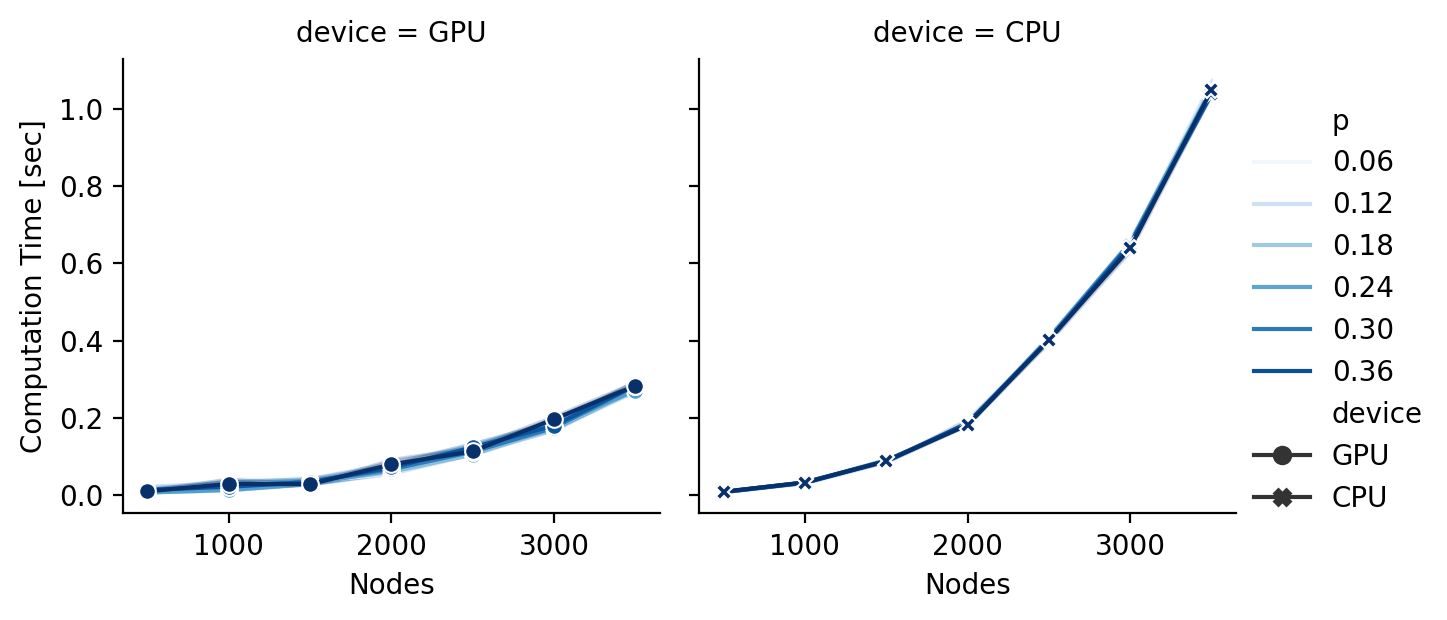

In [10]:
g = sns.relplot(
    data=times,
    x="n",
    y="computation_time",
    hue="p",
    col="device",
    kind="line",
    markers=True,
    style="device",
    dashes=False,
    palette="Blues",
    height=3.2,
)
g.set_xlabels("Nodes")
g.set_ylabels("Computation Time [sec]")

/var/folders/l9/n_7g_6jn18b24tz8qvw1rgd40000gn/T/ipykernel_12815/4129671821.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_yticklabels([f"x{t}" for t in g.ax.get_yticks()])


[Text(0, 0.5, 'x0.5'),
 Text(0, 1.0, 'x1.0'),
 Text(0, 1.5, 'x1.5'),
 Text(0, 2.0, 'x2.0'),
 Text(0, 2.5, 'x2.5'),
 Text(0, 3.0, 'x3.0'),
 Text(0, 3.5, 'x3.5'),
 Text(0, 4.0, 'x4.0')]

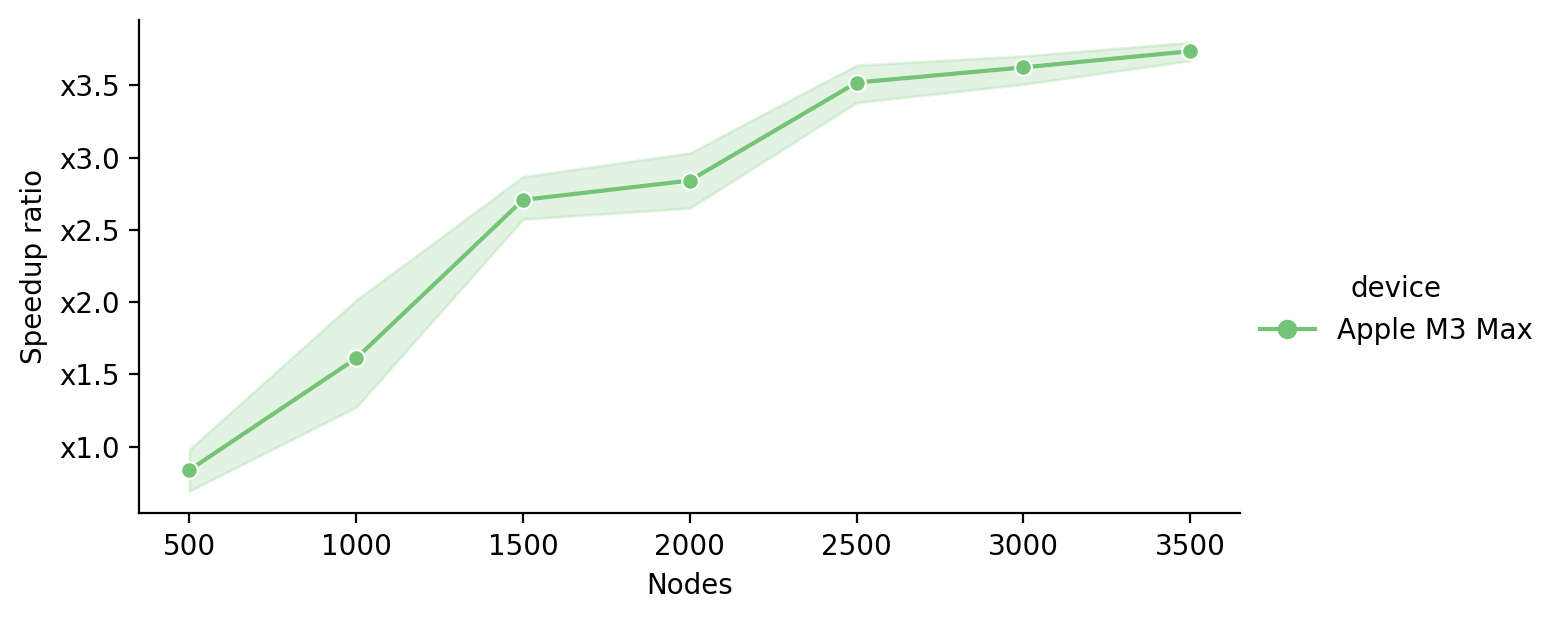

In [11]:
speedup = (
    times.groupby(["n", "p", "device", "random_state"])["computation_time"]
    .mean()
    .unstack(["device"])
    .assign(speedup=lambda df: df["CPU"] / df["GPU"])
    .reset_index()
    .assign(device=system_info["gpus_compute"][-1])
)

g = sns.relplot(
    x="n",
    y="speedup",
    hue="device",
    style="device",
    data=speedup,
    kind="line",
    markers=True,
    height=3.2,
    aspect=2,
    palette="Greens",
)
g.set_xlabels("Nodes")
g.set_ylabels("Speedup ratio")
g.ax.set_yticklabels([f"x{t}" for t in g.ax.get_yticks()])